This function `extract_save` can extract data from the XML file used to backup messages. It extracts:

1. Body of the message in English or Hindi
2. Date stamp
3. Date Sent
4. Service Center Number
5. Human-readable Date & Time
6. Message Title

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import csv

def _extract_sms_data(xml_file_path):
    # Parse the XML file with explicit UTF-8 encoding
    try:
        with open(xml_file_path, encoding='utf-8') as file:
            tree = ET.parse(file)
            root = tree.getroot()
    except FileNotFoundError:
        print(f"Error: File {xml_file_path} not found.")
        return None
    except ET.ParseError:
        print("Error: Invalid XML format.")
        return None
    except UnicodeDecodeError:
        print("Error: Unable to decode file with UTF-8 encoding.")
        return None

    # List to store extracted data
    data = []

    # Define the properties to extract
    properties = ['address', 'body', 'readable_date', 'service_center', 'date', 'date_sent']

    # Iterate through each <sms> element
    for sms in root.findall('sms'):
        # Extract specified attributes, use None if attribute is missing
        sms_data = {prop: sms.get(prop, None) for prop in properties}
        data.append(sms_data)

    # Create DataFrame
    df = pd.DataFrame(data, columns=properties)
    return df

def extract_save(xml_file_path, save_path='sms_data.csv'):
    df = _extract_sms_data(xml_file_path)
    print(df)
    if df is not None:
        # Save DataFrame to CSV with UTF-8 encoding to preserve Hindi text
        df.to_csv(save_path, index=False, encoding='utf-8-sig')
        print(f"\nDataFrame saved to {save_path} with UTF-8 encoding")

In [2]:
# extract_save('sms-20250722210237.xml','one.csv')
# extract_save('sms-20250724144910.xml','two.csv')

In [3]:
import pandas as pd
df = _extract_sms_data('sms-20250724144910.xml')
df.add(_extract_sms_data('sms-20250722210237.xml'))
df.head()

address                                               body  \
0  JZ-JioPay  आपके जियो नंबर 8299235444 के लिए रु. 298.0 का ...   
1  BP-AAAOTP  <#> 290-086 is One Time Password (OTP) to veri...   
2  QP-LEVISL  Last 3 days of Levi's End Of Season Sale.\n\nG...   
3  JD-JioBln  \nVoice Call\nUsed: 6 min 45 sec\n\nPack Used:...   
4  JD-JioBln  \nVoice Call\nUsed: 5 min 24 sec\n\nPack Used:...   

              readable_date service_center           date      date_sent  
0  Aug 20, 2020 12:56:02 PM           null  1597908362501  1597908349000  
1   Aug 20, 2020 1:23:15 PM           null  1597909995400  1597866794000  
2   Aug 20, 2020 2:55:37 PM           null  1597915537195  1597915531000  
3   Aug 20, 2020 7:38:32 PM           null  1597932512206              0  
4   Aug 20, 2020 7:45:58 PM           null  1597932958544              0

In [4]:
!pip install langdetect pandas

In [23]:
import re
def clean_message(text):
    text = str(text)
    # print('\n',text,'\n')
    text = re.sub(r'\d{4,}', ' [NUM] ', text) # replace long numbers
    # print(text)
    text = re.sub(r'http\S+', ' [URL] ', text) # replace URLs
    # print(text)
    text = re.sub(r'[^\w\s\u0900-\u097F]', '', text) # Remove special char except hindi
    # print(text)
    text = re.sub(r'\s+', ' ', text) # normalize spaces
    # print('\n',text,'\n')
    return text.strip()

from langdetect import detect
def detect_language(text):
    try:
        lang = detect(text)
        return 'en' if lang!='hi' else lang # ex. 'en', 'hi'
    except:
        return 'unknown'

# print(df['body'].iloc[1])

df['cleaned_message'] = df['body'].apply(clean_message)
df['language'] = df['body'].apply(detect_language)
df.head()

    

address                                               body  \
0  JZ-JioPay  आपके जियो नंबर 8299235444 के लिए रु. 298.0 का ...   
1  BP-AAAOTP  <#> 290-086 is One Time Password (OTP) to veri...   
2  QP-LEVISL  Last 3 days of Levi's End Of Season Sale.\n\nG...   
3  JD-JioBln  \nVoice Call\nUsed: 6 min 45 sec\n\nPack Used:...   
4  JD-JioBln  \nVoice Call\nUsed: 5 min 24 sec\n\nPack Used:...   

              readable_date service_center           date      date_sent  \
0  Aug 20, 2020 12:56:02 PM           null  1597908362501  1597908349000   
1   Aug 20, 2020 1:23:15 PM           null  1597909995400  1597866794000   
2   Aug 20, 2020 2:55:37 PM           null  1597915537195  1597915531000   
3   Aug 20, 2020 7:38:32 PM           null  1597932512206              0   
4   Aug 20, 2020 7:45:58 PM           null  1597932958544              0   

                                     cleaned_message language  \
0  आपके जियो नंबर NUM के लिए रु 2980 का पहला रीचा...       hi   
1  290086 is One Time Password OTP to verify your...       en   
2  Last 3 days of Levis End Of Season Sale Get ap...       en   
3  Voice Call Used 6 min 45 sec Pack Used Voice N...       en   
4  Voice Call Used 5 min 24 sec Pack Used Voice N...       en   

                                     tokens_combined  
0  [आपके, जियो, नंबर, NUM, रु, 2980, पहला, रीचार्...  
1  [290086, Time, Password, OTP, verify, mobile, ...  
2  [3, days, Levis, End, Season, Sale, apparel, w...  
3  [Voice, Call, 6, min, 45, sec, Pack, Voice, Ji...  
4  [Voice, Call, 5, min, 24, sec, Pack, Voice, Ji...

In [24]:
!pip install nltk indic-nlp-library

In [25]:
print({x: df[df['language'] == x].shape[0] for x in df['language'].unique()})
df[df['language'] == 'unknown']

{'hi': 827, 'en': 8552, 'unknown': 26}


address                                              body  \
221   +918957262940                                       76519 17904   
566        59029411                                            868538   
963   +918528847458                                        9450810300   
1152  +918957262940                                        8299407398   
1164  +918840758220                      Saurabhrathore9451@gmail.com   
1240  +917355079152                                                     
1722  +918957262940                                       96288 34252   
2742  +919339524463  https://hospitalappointmen2.wixsite.com/hospital   
3501  +917207778662                                                ??   
4705  +917887229095                                                ??   
5092  +916386235583                                     +916386235583   
5289  +918687850810                                     +916386235583   
5302  +917887229095                                                 ?   
5304  +917887229095                                                 ?   
5341  +916396944016                                                 ?   
5807  +919870995922                                                 ?   
5819  +917887229095                                                 ?   
6057  +918279614678                                        9837000614   
6573  +916307346257                                                 ?   
6577  +916307346257                                                ?    
6732  +916386235583                         kahkashakhan296@gmail.com   
6733  +916386235583                                         Noor@5669   
7446  +919458557740                                             \n\n?   
7449  +917887229095                                                 ?   
7451  +917887229095                                                 ?   
8618     8171661365                                        8700192099   

                 readable_date service_center           date      date_sent  \
221     Dec 1, 2020 1:43:07 PM           null  1606810387612  1606810388000   
566    Feb 7, 2021 12:38:47 PM           null  1612681727955  1612681726000   
963    Jun 17, 2021 9:32:12 PM           null  1623945732019  1623945726000   
1152  Aug 11, 2021 12:09:07 PM           null  1628663947543  1628663947000   
1164   Aug 13, 2021 7:18:09 PM           null  1628862489343  1628862490000   
1240   Aug 25, 2021 6:30:46 PM           null  1629896446519  1629896446000   
1722   Nov 11, 2021 4:10:43 PM           null  1636627243062  1636627242000   
2742    Dec 3, 2022 3:37:17 PM           null  1670062037004  1670062035000   
3501    Jun 8, 2023 3:08:22 PM           null  1686217102144  1686217104463   
4705   Jan 23, 2024 9:05:01 AM  +917012075009  1705980901303  1705980899000   
5092   Mar 22, 2024 2:26:15 PM           null  1711097775300  1711097778032   
5289   Apr 20, 2024 6:39:37 PM           null  1713618577294  1713618578878   
5302  Apr 25, 2024 12:28:28 PM  +917012075009  1714028308331  1714028307000   
5304  Apr 25, 2024 12:32:28 PM           null  1714028548346  1714028550354   
5341    May 2, 2024 2:43:53 PM           null  1714641233211  1714641234885   
5807   Aug 3, 2024 10:59:56 AM           null  1722662996443  1722662998929   
5819   Aug 4, 2024 10:18:01 AM           null  1722746881618  1722746884943   
6057   Aug 26, 2024 7:55:47 PM  +917012075009  1724682347189  1724682347000   
6573  Oct 28, 2024 10:46:29 AM           null  1730092589239  1730092591099   
6577  Oct 28, 2024 10:47:01 AM  +917012075009  1730092621620  1730092622000   
6732  Nov 20, 2024 10:33:00 PM           null  1732122180627  1732122184103   
6733  Nov 20, 2024 10:33:14 PM           null  1732122194492  1732122195833   
7446   Mar 7, 2025 10:26:18 AM           null  1741323378161  1741323380696   
7449   Mar 7, 2025 11:15:14 AM           null  1741326314993  1741326316566   
7451   Mar 7, 2025 11:16:25 AM  +917012075009  1741326385507  174

In [26]:
!pip install indic-nlp-library

In [27]:
# Removing stop words
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
eng_stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhsuh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
hinglish_stop = set({
    'aadi', 'aaj', 'aap', 'aapne', 'aata', 'aati', 'aaya', 'aaye', 'ababbe', 'abbey', 'abe', 'abhi',
    'able', 'about', 'above', 'accha', 'according', 'accordingly', 'acha', 'achcha', 'across',
    'actually', 'after', 'afterwards', 'again', 'against', 'agar', 'ain', 'aint', "ain't", 'aisa',
    'aise', 'aisi', 'alag', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also',
    'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'andar', 'another', 'any', 'anybody',
    'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'ap', 'apan', 'apart', 'apna',
    'apnaa', 'apne', 'apni', 'appear', 'are', 'aren', 'arent', "aren't", 'around', 'arre', 'as',
    'aside', 'ask', 'asking', 'at', 'aur', 'avum', 'aya', 'aye', 'baad', 'baar', 'bad', 'bahut',
    'bana', 'banae', 'banai', 'banao', 'banaya', 'banaye', 'banayi', 'banda', 'bande', 'bandi', 'bane',
    'bani', 'bas', 'bata', 'batao', 'bc', 'be', 'became', 'because', 'become', 'becomes', 'becoming',
    'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'best', 'better',
    'between', 'beyond', 'bhai', 'bheetar', 'bhi', 'bhitar', 'bht', 'bilkul', 'bohot', 'bol', 'bola',
    'bole', 'boli', 'bolo', 'bolta', 'bolte', 'bolti', 'both', 'brief', 'bro', 'btw', 'but', 'by',
    'came', 'can', 'cannot', 'cant', "can't", 'cause', 'causes', 'certain', 'certainly', 'chahiye',
    'chaiye', 'chal', 'chalega', 'chhaiye', 'clearly', "c'mon", 'com', 'come', 'comes', 'could',
    'couldn', 'couldnt', "couldn't", 'd', 'de', 'dede', 'dega', 'degi', 'dekh', 'dekha', 'dekhe',
    'dekhi', 'dekho', 'denge', 'dhang', 'di', 'did', 'didn', 'didnt', "didn't", 'dijiye', 'diya',
    'diyaa', 'diye', 'diyo', 'do', 'does', 'doesn', 'doesnt', "doesn't", 'doing', 'done', 'dono',
    'dont', "don't", 'doosra', 'doosre', 'down', 'downwards', 'dude', 'dunga', 'dungi', 'during',
    'dusra', 'dusre', 'dusri', 'dvaara', 'dvara', 'dwaara', 'dwara', 'each', 'edu', 'eg', 'eight',
    'either', 'ek', 'else', 'elsewhere', 'enough', 'etc', 'even', 'ever', 'every', 'everybody',
    'everyone', 'everything', 'everywhere', 'ex', 'exactly', 'example', 'except', 'far', 'few',
    'fifth', 'fir', 'first', 'five', 'followed', 'following', 'follows', 'for', 'forth', 'four',
    'from', 'further', 'furthermore', 'gaya', 'gaye', 'gayi', 'get', 'gets', 'getting', 'ghar',
    'given', 'gives', 'go', 'goes', 'going', 'gone', 'good', 'got', 'gotten', 'greetings', 'guys',
    'haan', 'had', 'hadd', 'hadn', 'hadnt', "hadn't", 'hai', 'hain', 'hamara', 'hamare', 'hamari',
    'hamne', 'han', 'happens', 'har', 'hardly', 'has', 'hasn', 'hasnt', "hasn't", 'have', 'haven',
    'havent', "haven't", 'having', 'he', 'hello', 'help', 'hence', 'her', 'here', 'hereafter',
    'hereby', 'herein', "here's", 'hereupon', 'hers', 'herself', "he's", 'hi', 'him', 'himself',
    'his', 'hither', 'hm', 'hmm', 'ho', 'hoga', 'hoge', 'hogi', 'hona', 'honaa', 'hone', 'honge',
    'hongi', 'honi', 'hopefully', 'hota', 'hotaa', 'hote', 'hoti', 'how', 'howbeit', 'however',
    'hoyenge', 'hoyengi', 'hu', 'hua', 'hue', 'huh', 'hui', 'hum', 'humein', 'humne', 'hun', 'huye',
    'huyi', 'i', "i'd", 'idk', 'ie', 'if', "i'll", "i'm", 'imo', 'in', 'inasmuch', 'inc', 'inhe',
    'inhi', 'inho', 'inka', 'inkaa', 'inke', 'inki', 'inn', 'inner', 'inse', 'insofar', 'into',
    'inward', 'is', 'ise', 'isi', 'iska', 'iskaa', 'iske', 'iski', 'isme', 'isn', 'isne', 'isnt',
    "isn't", 'iss', 'isse', 'issi', 'isski', 'it', "it'd", "it'll", 'itna', 'itne', 'itni', 'itno',
    'its', "it's", 'itself', 'ityaadi', 'ityadi', "i've", 'ja', 'jaa', 'jab', 'jabh', 'jaha',
    'jahaan', 'jahan', 'jaisa', 'jaise', 'jaisi', 'jata', 'jayega', 'jidhar', 'jin', 'jinhe', 'jinhi',
    'jinho', 'jinhone', 'jinka', 'jinke', 'jinki', 'jinn', 'jis', 'jise', 'jiska', 'jiske', 'jiski',
    'jisme', 'jiss', 'jisse', 'jitna', 'jitne', 'jitni', 'jo', 'just', 'jyaada', 'jyada', 'k', 'ka',
    'kaafi', 'kab', 'kabhi', 'kafi', 'kaha', 'kahaa', 'kahaan', 'kahan', 'kahi', 'kahin', 'kahte',
    'kaisa', 'kaise', 'kaisi', 'kal', 'kam', 'kar', 'kara', 'kare', 'karega', 'karegi', 'karen',
    'karenge', 'kari', 'karke', 'karna', 'karne', 'karni', 'karo', 'karta', 'karte', 'karti', 'karu',
    'karun', 'karunga', 'karungi', 'kaun', 'kaunsa', 'kayi', 'kch', 'ke', 'keep', 'keeps', 'keh',
    'kehte', 'kept', 'khud', 'ki', 'kin', 'kine', 'kinhe', 'kinho', 'kinka', 'kinke', 'kinki', 'kinko',
    'kinn', 'kino', 'kis', 'kise', 'kisi', 'kiska', 'kiske', 'kiski', 'kisko', 'kisliye', 'kisne',
    'kitna', 'kitne', 'kitni', 'kitno', 'kiya', 'kiye', 'know', 'known', 'knows', 'ko', 'koi', 'kon',
    'konsa', 'koyi', 'krna', 'krne', 'kuch', 'kuchch', 'kuchh', 'kul', 'kull', 'kya', 'kyaa', 'kyu',
    'kyuki', 'kyun', 'kyunki', 'lagta', 'lagte', 'lagti', 'last', 'lately', 'later', 'le', 'least',
    'lekar', 'lekin', 'less', 'lest', 'let', "let's", 'li', 'like', 'liked', 'likely', 'little',
    'liya', 'liye', 'll', 'lo', 'log', 'logon', 'lol', 'look', 'looking', 'looks', 'ltd', 'lunga',
    'm', 'maan', 'maana', 'maane', 'maani', 'maano', 'magar', 'mai', 'main', 'maine', 'mainly',
    'mana', 'mane', 'mani', 'mano', 'many', 'mat', 'may', 'maybe', 'me', 'mean', 'meanwhile', 'mein',
    'mera', 'mere', 'merely', 'meri', 'might', 'mightn', 'mightnt', "mightn't", 'mil', 'mjhe',
    'more', 'moreover', 'most', 'mostly', 'much', 'mujhe', 'must', 'mustn', 'mustnt', "mustn't",
    'my', 'myself', 'na', 'naa', 'naah', 'nahi', 'nahin', 'nai', 'name', 'namely', 'nd', 'ne', 'near',
    'nearly', 'necessary', 'neeche', 'need', 'needn', 'neednt', "needn't", 'needs', 'neither',
    'never', 'nevertheless', 'new', 'next', 'nhi', 'nine', 'no', 'nobody', 'non', 'none', 'noone',
    'nope', 'nor', 'normally', 'not', 'nothing', 'novel', 'now', 'nowhere', 'o', 'obviously', 'of',
    'off', 'often', 'oh', 'ok', 'okay', 'old', 'on', 'once', 'one', 'ones', 'only', 'onto', 'or',
    'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 'over',
    'overall', 'own', 'par', 'pata', 'pe', 'pehla', 'pehle', 'pehli', 'people', 'per', 'perhaps',
    'phla', 'phle', 'phli', 'placed', 'please', 'plus', 'poora', 'poori', 'provides', 'pura', 'puri',
    'q', 'que', 'quite', 'raha', 'rahaa', 'rahe', 'rahi', 'rakh', 'rakha', 'rakhe', 'rakhen', 'rakhi',
    'rakho', 'rather', 're', 'really', 'reasonably', 'regarding', 'regardless', 'regards', 'rehte',
    'rha', 'rhaa', 'rhe', 'rhi', 'ri', 'right', 's', 'sa', 'saara', 'saare', 'saath', 'sab', 'sabhi',
    'sabse', 'sahi', 'said', 'sakta', 'saktaa', 'sakte', 'sakti', 'same', 'sang', 'sara', 'sath',
    'saw', 'say', 'saying', 'says', 'se', 'second', 'secondly', 'see', 'seeing', 'seem', 'seemed',
    'seeming', 'seems', 'seen', 'self', 'selves', 'sensible', 'sent', 'serious', 'seriously', 'seven',
    'several', 'shall', 'shan', 'shant', "shan't", 'she', "she's", 'should', 'shouldn', 'shouldnt',
    "shouldn't", "should've", 'si', 'sir', 'sir.', 'since', 'six', 'so', 'soch', 'some', 'somebody',
    'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 'soon',
    'still', 'sub', 'such', 'sup', 'sure', 't', 'tab', 'tabh', 'tak', 'take', 'taken', 'tarah',
    'teen', 'teeno', 'teesra', 'teesre', 'teesri', 'tell', 'tends', 'tera', 'tere', 'teri', 'th',
    'tha', 'than', 'thank', 'thanks', 'thanx', 'that', "that'll", 'thats', "that's", 'the', 'theek',
    'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby',
    'therefore', 'therein', "there's", 'thereupon', 'these', 'they', "they'd", "they'll", "they're",
    "they've", 'thi', 'thik', 'thing', 'think', 'thinking', 'third', 'this', 'tho', 'thoda', 'thodi',
    'thorough', 'thoroughly', 'those', 'though', 'thought', 'three', 'through', 'throughout', 'thru',
    'thus', 'tjhe', 'to', 'together', 'toh', 'too', 'took', 'toward', 'towards', 'tried', 'tries',
    'true', 'truly', 'try', 'trying', 'tu', 'tujhe', 'tum', 'tumhara', 'tumhare', 'tumhari', 'tune',
    'twice', 'two', 'um', 'umm', 'un', 'under', 'unhe', 'unhi', 'unho', 'unhone', 'unka', 'unkaa',
    'unke', 'unki', 'unko', 'unless', 'unlikely', 'unn', 'unse', 'until', 'unto', 'up', 'upar',
    'upon', 'us', 'use', 'used', 'useful', 'uses', 'usi', 'using', 'uska', 'uske', 'usne', 'uss',
    'usse', 'ussi', 'usually', 'vaala', 'vaale', 'vaali', 'vahaan', 'vahan', 'vahi', 'vahin', 'vaisa',
    'vaise', 'vaisi', 'vala', 'vale', 'vali', 'various', 've', 'very', 'via', 'viz', 'vo', 'waala',
    'waale', 'waali', 'wagaira', 'wagairah', 'wagerah', 'waha', 'wahaan', 'wahan', 'wahi', 'wahin',
    'waisa', 'waise', 'waisi', 'wala', 'wale', 'wali', 'want', 'wants', 'was', 'wasn', 'wasnt',
    "wasn't", 'way', 'we', "we'd", 'well', "we'll", 'went', 'were', "we're", 'weren', 'werent',
    "weren't", "we've", 'what', 'whatever', "what's", 'when', 'whence', 'whenever', 'where',
    'whereafter', 'whereas', 'whereby', 'wherein', "where's", 'whereupon', 'wherever', 'whether',
    'which', 'while', 'who', 'whoever', 'whole', 'whom', "who's", 'whose', 'why', 'will', 'willing',
    'with', 'within', 'without', 'wo', 'woh', 'wohi', 'won', 'wont', "won't", 'would', 'wouldn',
    'wouldnt', "wouldn't", 'y', 'ya', 'yadi', 'yah', 'yaha', 'yahaan', 'yahan', 'yahi', 'yahin', 'ye',
    'yeah', 'yeh', 'yehi', 'yes', 'yet', 'you', "you'd", "you'll", 'your', "you're", 'yours',
    'yourself', 'yourselves', "you've", 'yup'
})

In [29]:
hindi_stop = set(["अंदर","अत","अदि","अप","अपना","अपनि","अपनी","अपने","अभि",
                  "अभी","आदि","आप","इंहिं","इंहें","इंहों","इतयादि","इत्यादि","इन",
                  "इनका","इन्हीं","इन्हें","इन्हों","इस","इसका","इसकि","इसकी","इसके",
                  "इसमें","इसि","इसी","इसे","उंहिं","उंहें","उंहों","उन","उनका","उनकि",
                  "उनकी","उनके","उनको","उन्हीं","उन्हें","उन्हों","उस","उसके","उसि",
                  "उसी","उसे","एक","एवं","एस","एसे","ऐसे","ओर","और","कइ","कई",
                  "कर","करता","करते","करना","करने","करें","कहते","कहा","का","काफि",
                  "काफ़ी","कि","किंहें","किंहों","कितना","किन्हें","किन्हों","किया","किर","किस",
                  "किसि","किसी","किसे","की","कुछ","कुल","के","को","कोइ","कोई","कोन",
                  "कोनसा","कौन","कौनसा","गया","घर","जब","जहाँ","जहां","जा","जिंहें","जिंहों",
                  "जितना","जिधर","जिन","जिन्हें","जिन्हों","जिस","जिसे","जीधर","जेसा","जेसे",
                  "जैसा","जैसे","जो","तक","तब","तरह","तिंहें","तिंहों","तिन","तिन्हें","तिन्हों",
                  "तिस","तिसे","तो","था","थि","थी","थे","दबारा","दवारा","दिया","दुसरा","दुसरे",
                  "दूसरे","दो","द्वारा","न","नहिं","नहीं","ना","निचे","निहायत","नीचे","ने","पर",
                  "पहले","पुरा","पूरा","पे","फिर","बनि","बनी","बहि","बही","बहुत","बाद",
                  "बाला","बिलकुल","भि","भितर","भी","भीतर","मगर","मानो","मे","में","यदि",
                  "यह","यहाँ","यहां","यहि","यही","या","यिह","ये","रखें","रवासा","रहा","रहे",
                  "ऱ्वासा","लिए","लिये","लेकिन","व","वगेरह","वरग","वर्ग","वह","वहाँ","वहां",
                  "वहिं","वहीं","वाले","वुह","वे","वग़ैरह","संग","सकता","सकते","सबसे","सभि",
                  "सभी","साथ","साबुत","साभ","सारा","से","सो","हि","ही","हुअ","हुआ","हुइ",
                  "हुई","हुए","हे","हें","है","हैं","हो","होता","होति","होती","होते","होना","होने"])

In [30]:
combined_stopwords = eng_stop.union(hindi_stop).union(hinglish_stop)

In [31]:
from indicnlp.tokenize import indic_tokenize
import nltk
nltk.download('punkt_tab')
import pandas as pd
from nltk.tokenize import word_tokenize

def tokenize_combined(text):
    lang = detect_language(text)
    if lang=='en':
        tokens = word_tokenize(text)
    elif lang == 'hi':
        tokens = indic_tokenize.trivial_tokenize(text, lang='hi')
    # removing stop words
    filtered_tokens = [t for t in tokens if t.lower() not in combined_stopwords]
    return filtered_tokens

df['tokens_combined'] = df[(df['language'] == 'hi') | (df['language'] == 'en')]['cleaned_message'].apply(tokenize_combined)
df.head()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mhsuh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


address                                               body  \
0  JZ-JioPay  आपके जियो नंबर 8299235444 के लिए रु. 298.0 का ...   
1  BP-AAAOTP  <#> 290-086 is One Time Password (OTP) to veri...   
2  QP-LEVISL  Last 3 days of Levi's End Of Season Sale.\n\nG...   
3  JD-JioBln  \nVoice Call\nUsed: 6 min 45 sec\n\nPack Used:...   
4  JD-JioBln  \nVoice Call\nUsed: 5 min 24 sec\n\nPack Used:...   

              readable_date service_center           date      date_sent  \
0  Aug 20, 2020 12:56:02 PM           null  1597908362501  1597908349000   
1   Aug 20, 2020 1:23:15 PM           null  1597909995400  1597866794000   
2   Aug 20, 2020 2:55:37 PM           null  1597915537195  1597915531000   
3   Aug 20, 2020 7:38:32 PM           null  1597932512206              0   
4   Aug 20, 2020 7:45:58 PM           null  1597932958544              0   

                                     cleaned_message language  \
0  आपके जियो नंबर NUM के लिए रु 2980 का पहला रीचा...       hi   
1  290086 is One Time Password OTP to verify your...       en   
2  Last 3 days of Levis End Of Season Sale Get ap...       en   
3  Voice Call Used 6 min 45 sec Pack Used Voice N...       en   
4  Voice Call Used 5 min 24 sec Pack Used Voice N...       en   

                                     tokens_combined  
0  [आपके, जियो, नंबर, NUM, रु, 2980, पहला, रीचार्...  
1  [290086, Time, Password, OTP, verify, mobile, ...  
2  [3, days, Levis, End, Season, Sale, apparel, w...  
3  [Voice, Call, 6, min, 45, sec, Pack, Voice, Ji...  
4  [Voice, Call, 5, min, 24, sec, Pack, Voice, Ji...

In [32]:
df.to_excel('testing.xlsx', index=False)

In [33]:
!pip install scikit-learn

In [34]:
# import fasttext
# import fasttext.util

# fasttext.util.download_model('en',if_exist='ignore')
# fasttext.util.download_model('hi', if_exist='ignore')
# model_en = fasttext.load_model('cc.en.300.bin')
# model_hi = fasttext.load_model('cc.hi.300.bin')

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_0 = df[(df['language']=='hi') | (df['language']=='en')]

# Step 1: Convert list of tokens into joined strings
documents = df_0['tokens_combined'].apply(lambda tokens: ' '.join(tokens))

# Step 2: Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Step 3: Fit and transform the documents
X_tfidf = vectorizer.fit_transform(documents)

C:\Users\mhsuh\AppData\Local\Temp\ipykernel_3320\932431700.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['clusters'] = kmeans.fit_predict(X_tfidf)


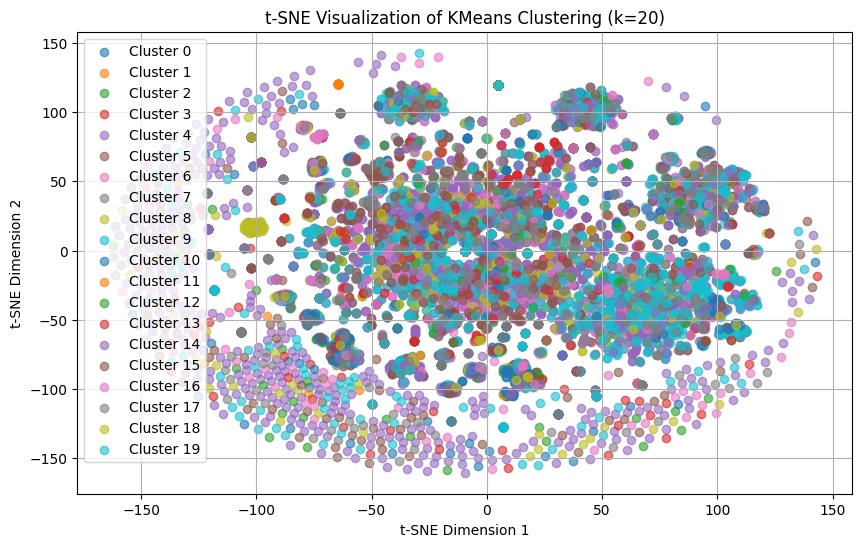

C:\Users\mhsuh\AppData\Local\Temp\ipykernel_3320\932431700.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['clusters'] = kmeans.fit_predict(X_tfidf)


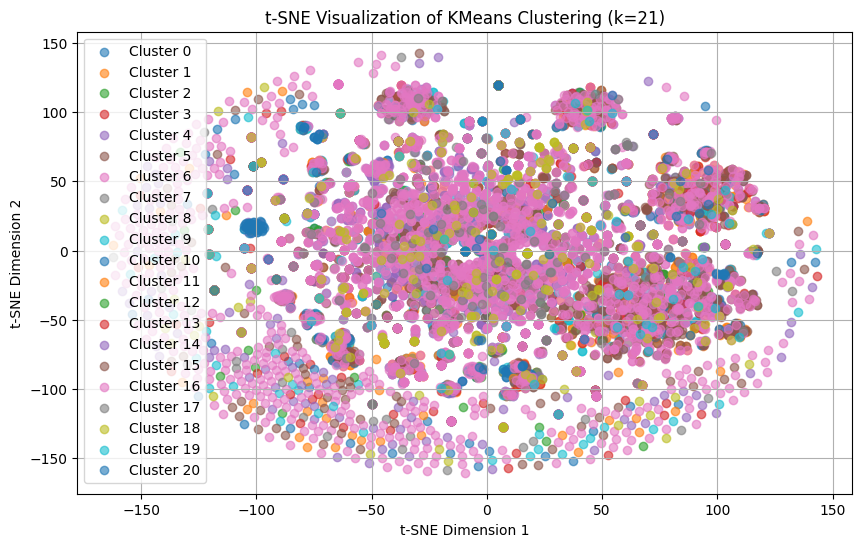

C:\Users\mhsuh\AppData\Local\Temp\ipykernel_3320\932431700.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['clusters'] = kmeans.fit_predict(X_tfidf)


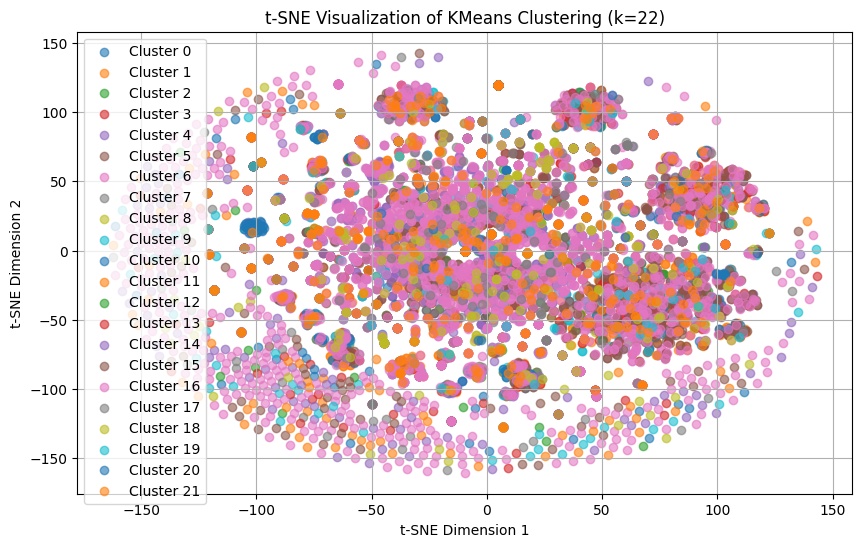

C:\Users\mhsuh\AppData\Local\Temp\ipykernel_3320\932431700.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['clusters'] = kmeans.fit_predict(X_tfidf)


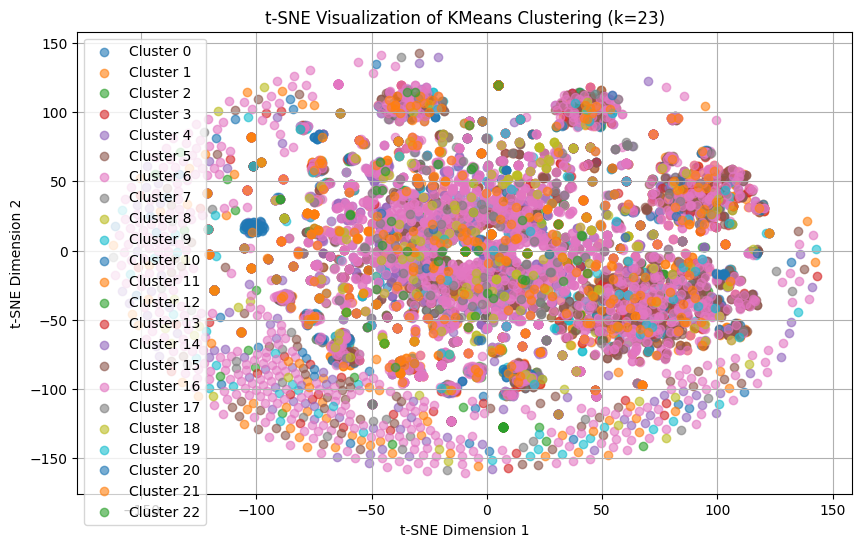

C:\Users\mhsuh\AppData\Local\Temp\ipykernel_3320\932431700.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['clusters'] = kmeans.fit_predict(X_tfidf)


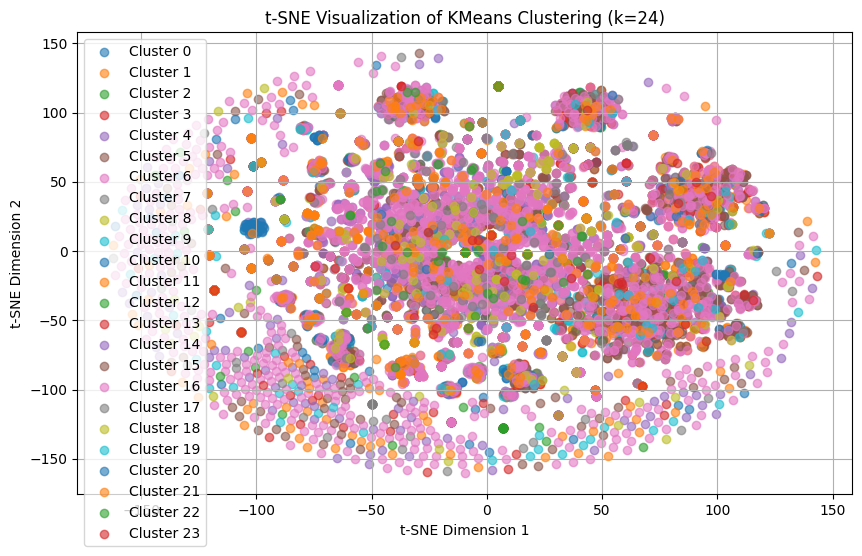

C:\Users\mhsuh\AppData\Local\Temp\ipykernel_3320\932431700.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['clusters'] = kmeans.fit_predict(X_tfidf)


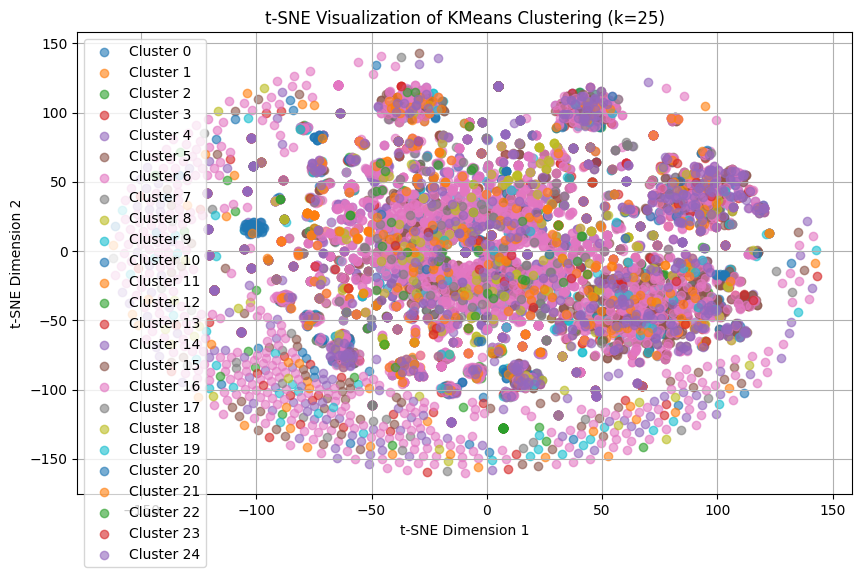

C:\Users\mhsuh\AppData\Local\Temp\ipykernel_3320\932431700.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['clusters'] = kmeans.fit_predict(X_tfidf)


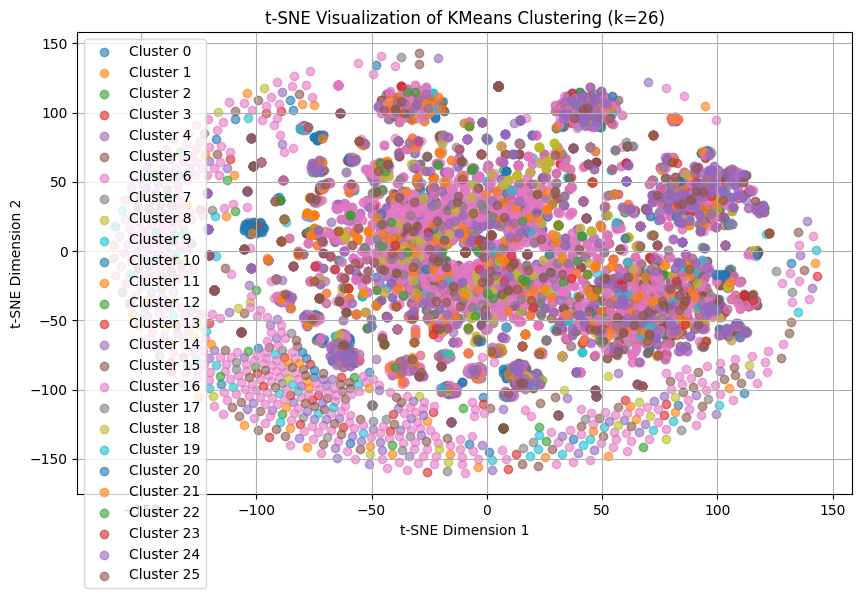

C:\Users\mhsuh\AppData\Local\Temp\ipykernel_3320\932431700.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['clusters'] = kmeans.fit_predict(X_tfidf)


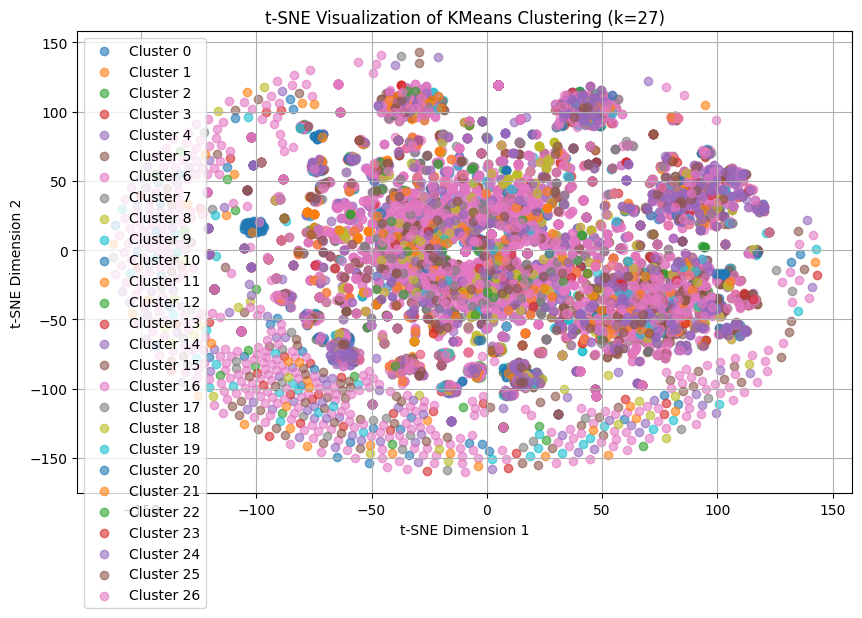

C:\Users\mhsuh\AppData\Local\Temp\ipykernel_3320\932431700.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['clusters'] = kmeans.fit_predict(X_tfidf)


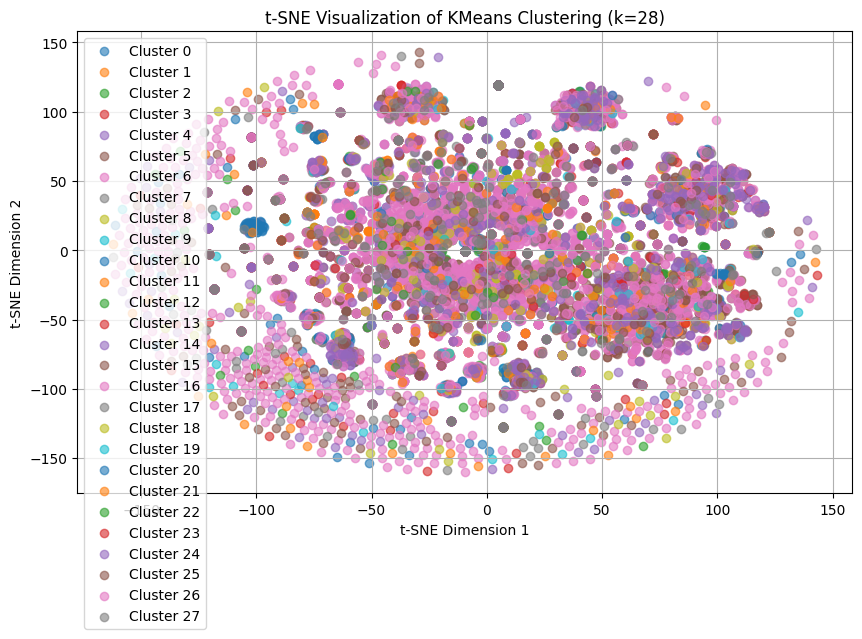

C:\Users\mhsuh\AppData\Local\Temp\ipykernel_3320\932431700.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['clusters'] = kmeans.fit_predict(X_tfidf)


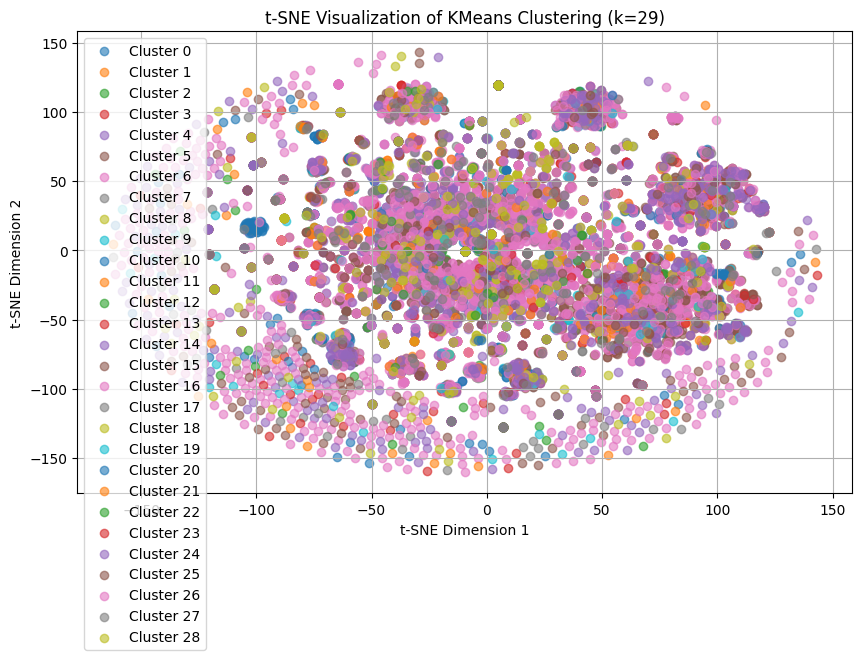

In [60]:
from sklearn.manifold import TSNE

for c in range(20, 30):
    # Cluster the TF-IDF matrix
    kmeans = KMeans(n_clusters=c, random_state=42)
    df_0['clusters'] = kmeans.fit_predict(X_tfidf)
    
    # Reduce dimensionality using t-SNE
    X_tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42).fit_transform(X_tfidf.toarray())
    
    df_plot = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
    df_plot['Cluster'] = df_0['clusters']
    
    plt.figure(figsize=(10, 6))
    for i in range(c):
        plt.scatter(
            df_plot[df_plot['Cluster'] == i]['Dim1'],
            df_plot[df_plot['Cluster'] == i]['Dim2'],
            label=f"Cluster {i}", alpha=0.6
        )
    
    plt.title(f"t-SNE Visualization of KMeans Clustering (k={c})")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.grid(True)
    plt.show()


In [50]:
for i in range(5):
    df_0[df_0['clusters']==i].to_excel(f"cluster_{i}.xlsx",index=False)

## Computing Cost

Gradient descent involves repeated steps to adjust the value of your parameter $(w,b)$ to gradually get a smaller and smaller cost $J(w,b)$.
- At each step of gradient descent, it will be helpful for you to monitor your progress by computing the cost $J(w,b)$ as $(w,b)$ gets updated. 
- In this section, you will implement a function to calculate $J(w,b)$ so that you can check the progress of your gradient descent implementation.

#### Cost function
As you may recall from the lecture, for one variable, the cost function for linear regression $J(w,b)$ is defined as

$$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2$$ 

- You can think of $f_{w,b}(x^{(i)})$ as the model's prediction of your restaurant's profit, as opposed to $y^{(i)}$, which is the actual profit that is recorded in the data.
- $m$ is the number of training examples in the dataset

#### Model prediction

- For linear regression with one variable, the prediction of the model $f_{w,b}$ for an example $x^{(i)}$ is representented as:

$$ f_{w,b}(x^{(i)}) = wx^{(i)} + b$$

This is the equation for a line, with an intercept $b$ and a slope $w$

In [38]:
def compute_cost(x, y, w, b): 
    """
    Computes the cost function for linear regression.
    
    Args:
        x (ndarray): Shape (m,) Input to the model (Population of cities) 
        y (ndarray): Shape (m,) Label (Actual profits for the cities)
        w, b (scalar): Parameters of the model
    
    Returns
        total_cost (float): The cost of using w,b as the parameters for linear regression
               to fit the data points in x and y
    """
    # number of training examples
    m = x.shape[0] 
    
    # You need to return this variable correctly
    total_cost = 0
    f_wb = w * x + b
    error = f_wb - y
    sq_error = error ** 2
    total_error = np.sum(sq_error)
    total_cost = total_error/(2*m)

    return total_cost

## Gradient descent
The gradient descent algorithm is:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & \phantom {0000} b := b -  \alpha \frac{\partial J(w,b)}{\partial b} \newline       \; & \phantom {0000} w := w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{1}  \; & 
\newline & \rbrace\end{align*}$$

where, parameters $w, b$ are both updated simultaniously and where  
$$
\frac{\partial J(w,b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \tag{2}
$$
$$
\frac{\partial J(w,b)}{\partial w}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) -y^{(i)})x^{(i)} \tag{3}
$$
* m is the number of training examples in the dataset

    
*  $f_{w,b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$, is the target value

* `compute_gradient` function calculates $\frac{\partial J(w)}{\partial w}$, $\frac{\partial J(w)}{\partial b}$ 

In [39]:
def compute_gradient(x, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      x (ndarray): Shape (m,) Input to the model (Population of cities) 
      y (ndarray): Shape (m,) Label (Actual profits for the cities)
      w, b (scalar): Parameters of the model  
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
     """
    
    # Number of training examples
    m = x.shape[0]
    
    # You need to return the following variables correctly
    dj_dw = 0
    dj_db = 0
    gradient = ( ( w * x + b ) - y )
    dj_db = np.sum(gradient)/m
    gradient = gradient * x
    dj_dw = np.sum(gradient)/m
    return dj_dw, dj_db

### Learning parameters using batch gradient descent

In [40]:
def gradient_descent(x, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      x :    (ndarray): Shape (m,)
      y :    (ndarray): Shape (m,)
      w_in, b_in : (scalar) Initial values of parameters of the model
      cost_function: function to compute cost
      gradient_function: function to compute the gradient
      alpha : (float) Learning rate
      num_iters : (int) number of iterations to run gradient descent
    Returns
      w : (ndarray): Shape (1,) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(x)
    
    # An array to store cost J and w's at each iteration — primarily for graphing later
    J_history = []
    w_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_dw, dj_db = gradient_function(x, y, w, b )  

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(x, y, w, b)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            w_history.append(w)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w, b, J_history, w_history #return w and J,w history for graphing